## Environment setup and data pre-processing

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from config import *

df = pd.read_csv(eur_usd_loc)
print(df.count())

# Rename bid OHLC columns
df.rename(columns={'Time': 'timestamp', 'Open': 'open', 'Close': 'close',
                   'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.astype(float)

# Add additional features
df['hour'] = df.index.hour
df['day'] = df.index.weekday
df['week'] = df.index.week
df['momentum'] = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high']) / 2
# df['range'] = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close']) / 4
df['oc_diff'] = df['open'] - df['close']

print(df.head())


def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)

X, y = create_dataset(dataset, look_back=50)
y = y[:, target_index]

train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

Using TensorFlow backend.
/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Time      245444
Open      245444
High      245444
Low       245444
Close     245444
Volume    245444
dtype: int64
                        open     high      low    close       volume  hour  \
timestamp                                                                    
2010-01-01 00:00:00  1.43283  1.43293  1.43224  1.43293  608600007.1     0   
2010-01-01 00:15:00  1.43285  1.43295  1.43229  1.43275  535600003.2     0   
2010-01-01 00:30:00  1.43280  1.43303  1.43239  1.43281  436299999.2     0   
2010-01-01 00:45:00  1.43285  1.43294  1.43229  1.43276  614299997.3     0   
2010-01-01 01:00:00  1.43287  1.43292  1.43206  1.43282  705300008.8     1   

                     day  week      momentum  avg_price  ohlc_price  oc_diff  
timestamp                                                                     
2010-01-01 00:00:00    4    53 -60860.000710   1.432585    1.432732 -0.00010  
2010-01-01 00:15:00    4    53  53560.000320   1.432620    1.432710  0.00010  
2010-01-01 00:30:00   

## Model creation

In [2]:
model = Sequential()
model.add(GRU(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(GRU(50, return_sequences=True))
model.add(GRU(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


2018-05-27 23:44:07,691 : WARNING : From /usr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1150: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2018-05-27 23:44:08,077 : WARNING : From /usr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1257: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50, 50)            9450      
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 50)            15150     
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 10)            1830      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 180       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total para

## Benchmark

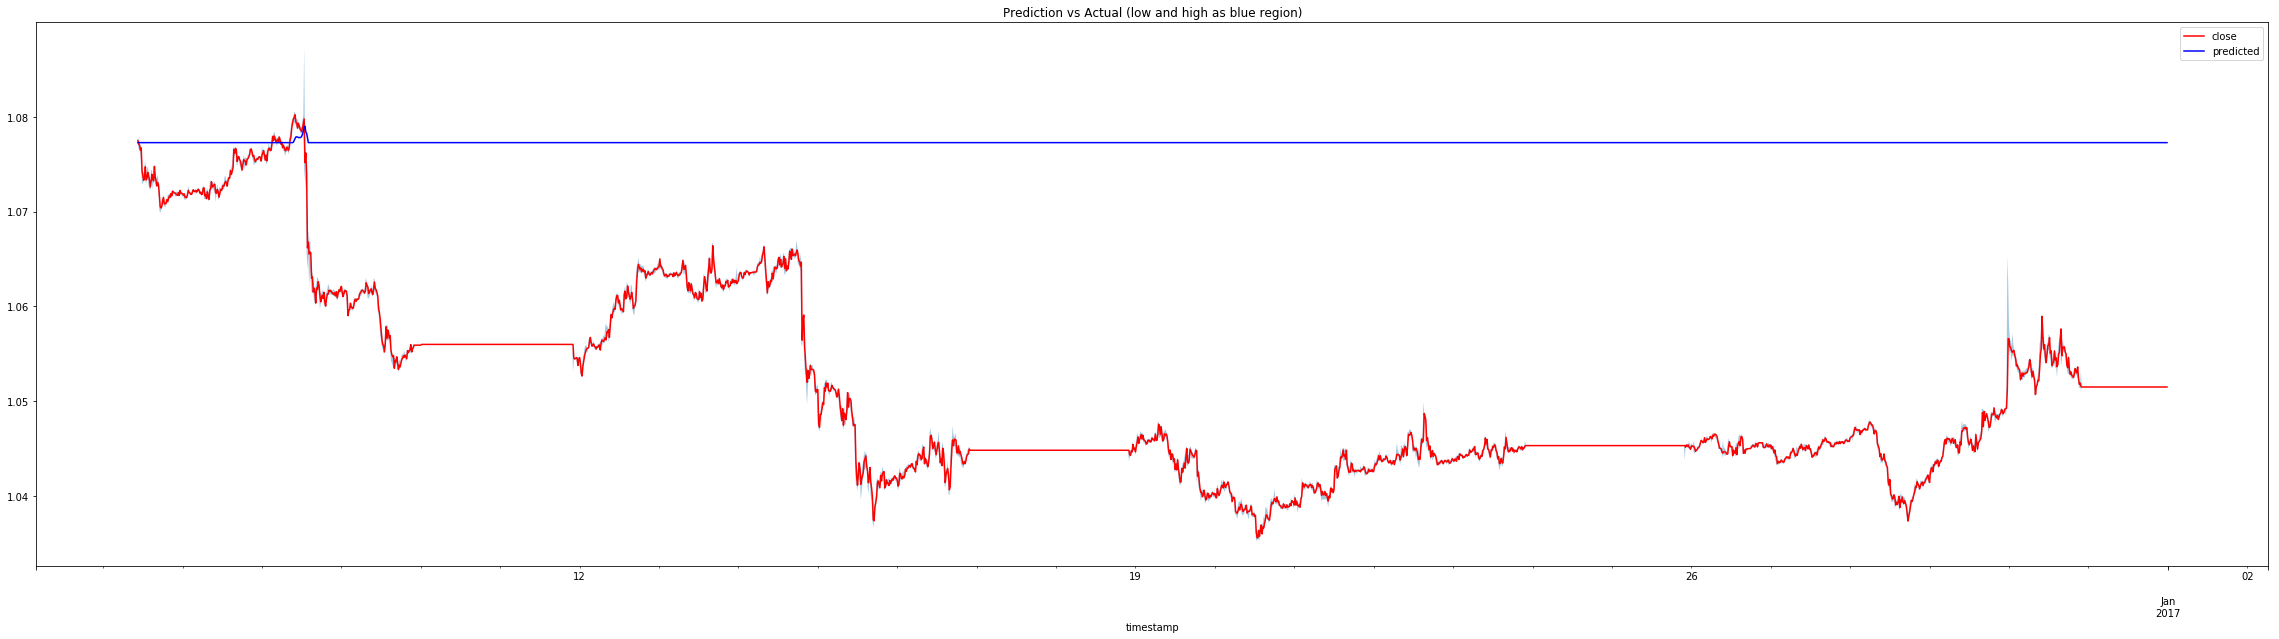

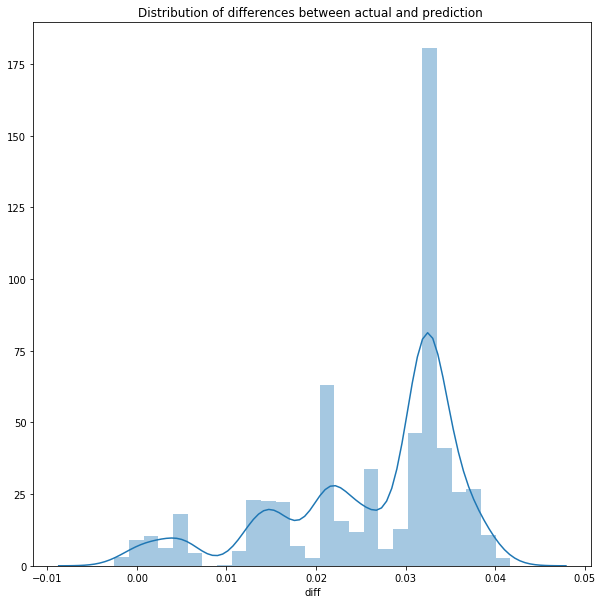

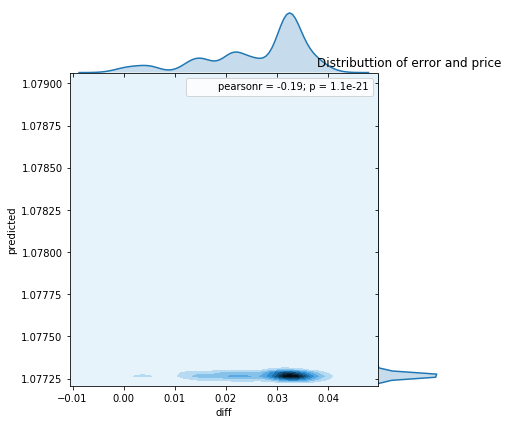

MSE :  0.0007788221697455181
MAE :  0.026117904067719574


count    2454.000000
mean        0.026096
std         0.009892
min        -0.002503
25%         0.021277
50%         0.031477
75%         0.032465
max         0.041667
Name: diff, dtype: float64

In [4]:
model.load_weights(baseline_wights_loc)

pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

ax = predictions.plot(x=predictions.index, y='close', c='red', figsize=(40, 10))
ax = predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40, 10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10, 10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()